In [10]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import chirp, tukey, fftconvolve, correlate
import matplotlib.pyplot as plt
import os

In [11]:
def generate_sine_sweep(fs, duration, f0, f1, method='logarithmic', amplitude=0.9, taper=0.1):
    """
    Generate a sine sweep signal.
    
    Parameters:
    - fs: sampling frequency in Hz
    - duration: sweep duration in seconds
    - f0: start frequency in Hz
    - f1: end frequency in Hz
    - method: 'logarithmic' or 'linear'
    - amplitude: peak amplitude of the sweep (0 to 1)
    - taper: fraction of signal duration to taper at both ends
    
    Returns:
    - sweep: the generated sine sweep signal
    """
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    sweep = amplitude * chirp(t, f0=f0, f1=f1, t1=duration, method=method)
    
    window = tukey(len(sweep), alpha=taper)
    sweep *= window
    
    return sweep

def generate_inverse_filter(sweep, fs, f0, f1, method='logarithmic'):
    """
    Generate an inverse filter for a given sweep signal.
    
    Parameters:
    - sweep: the input sweep signal
    - fs: sampling frequency in Hz
    - f0: start frequency in Hz
    - f1: end frequency in Hz
    - method: 'logarithmic' or 'linear'
    
    Returns:
    - inverse_filter: the generated inverse filter
    """
    t = np.arange(len(sweep)) / fs
    duration = len(sweep) / fs
    
    if method == 'logarithmic':
        omega1, omega2 = 2 * np.pi * f0, 2 * np.pi * f1
        envelope = np.exp(-t * omega1 * (np.log(omega2/omega1) / duration))
        inverse_filter = sweep[::-1] * envelope / (sweep * sweep[::-1]).mean()
    else:
        inverse_filter = sweep[::-1] / (sweep * sweep[::-1]).mean()
    
    return inverse_filter

def align_signals(recorded_sweep, reference_signal):
    """
    Align the recorded sweep with a reference signal.
    
    Parameters:
    - recorded_sweep: the recorded sweep signal
    - reference_signal: the reference signal to align with (e.g., inverse filter)
    
    Returns:
    - aligned_recorded: the aligned recorded sweep
    - aligned_reference: the aligned reference signal
    """
    correlation = correlate(recorded_sweep, reference_signal, mode='full')
    start_index = np.argmax(np.abs(correlation)) - len(reference_signal) + 1
    
    if start_index < 0:
        recorded_sweep = recorded_sweep[-start_index:]
        start_index = 0
    recorded_sweep = recorded_sweep[start_index:start_index+len(reference_signal)]
    
    min_length = min(len(recorded_sweep), len(reference_signal))
    aligned_recorded = recorded_sweep[:min_length]
    aligned_reference = reference_signal[:min_length]
    
    return aligned_recorded, aligned_reference

def compute_rir(recorded_sweep, inverse_filter, fs, keep_duration=10):
    """
    Compute the Room Impulse Response (RIR) from a recorded sweep and inverse filter.
    
    Parameters:
    - recorded_sweep: the recorded sweep signal
    - inverse_filter: the inverse filter
    - fs: sampling frequency in Hz
    - keep_duration: duration of RIR to keep after the main peak, in seconds
    
    Returns:
    - rir: the computed Room Impulse Response
    """
    rir = fftconvolve(recorded_sweep, inverse_filter, mode='full')
    
    peak_index = np.argmax(np.abs(rir))
    rir = np.roll(rir, -peak_index)[:int(fs * keep_duration)]
    
    fade_length = int(0.1 * fs)  # 100 ms fade
    fade_out = np.linspace(1, 0, fade_length)**2
    rir[-fade_length:] *= fade_out
    
    rir /= np.max(np.abs(rir))  # Normalize
    
    return rir

def plot_signal(signal, fs, title, xlabel='Time (s)', ylabel='Amplitude'):
    """
    Plot a signal in the time domain.
    
    Parameters:
    - signal: the signal to plot
    - fs: sampling frequency in Hz
    - title: plot title
    - xlabel: x-axis label
    - ylabel: y-axis label
    """
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(signal)) / fs, signal)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def plot_rir_and_spectrum(rir, fs):
    """
    Plot the RIR in time domain and its frequency spectrum.
    
    Parameters:
    - rir: Room Impulse Response
    - fs: sampling frequency in Hz
    """
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(rir)) / fs, rir)
    plt.title('Room Impulse Response')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    freq_response = np.abs(np.fft.rfft(rir))
    freq_axis = np.fft.rfftfreq(len(rir), d=1/fs)
    plt.semilogx(freq_axis, 20 * np.log10(freq_response))
    plt.title('Frequency Response of RIR')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.xlim(20, fs/2)
    plt.ylim(-60, 0)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Sine sweep generated and saved.


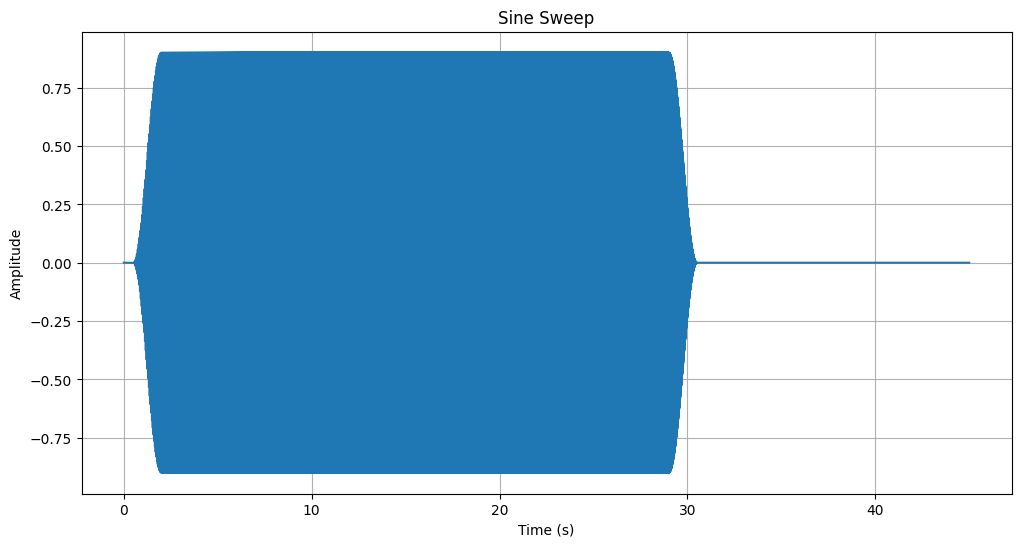

Sweep duration: 45.00 seconds
Sweep max amplitude: 0.9000


In [12]:
# Parameters
fs = 48000
duration = 45
sweep_duration = 30
f0 = 20
f1 = 20000

# Generate sweep
sweep = generate_sine_sweep(fs, sweep_duration, f0, f1)

# Add silence
silence_start = int(0.5 * fs)
silence_end = int((duration - sweep_duration - 0.5) * fs)
sweep_with_silence = np.pad(sweep, (silence_start, silence_end), 'constant')

# Save the sweep
wavfile.write('sine_sweep.wav', fs, np.int16(sweep_with_silence * 32767))

print("Sine sweep generated and saved.")

# Plot the sweep
plot_signal(sweep_with_silence, fs, 'Sine Sweep')

# Print statistics
print(f"Sweep duration: {len(sweep_with_silence)/fs:.2f} seconds")
print(f"Sweep max amplitude: {np.max(np.abs(sweep_with_silence)):.4f}")

Inverse filter generated and saved.


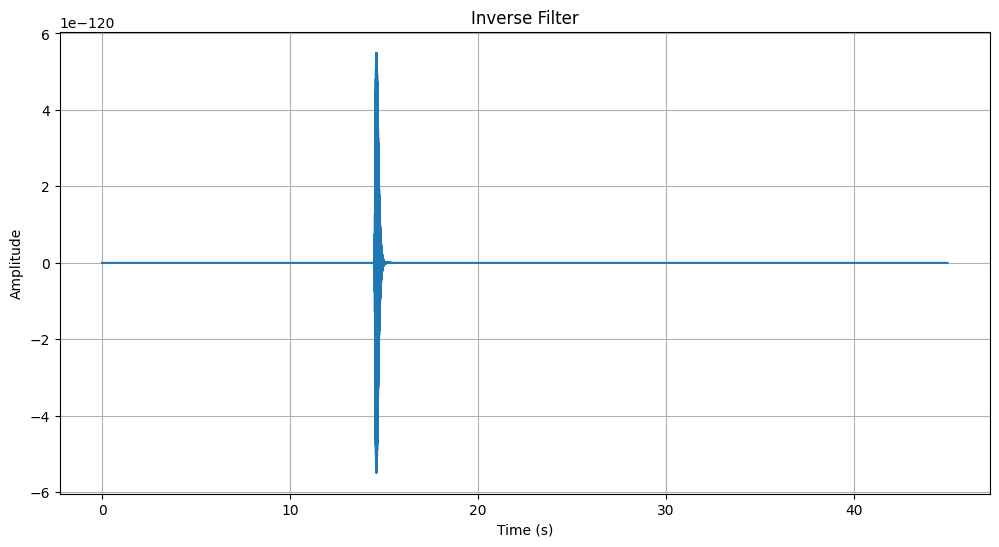

Inverse filter duration: 45.00 seconds
Inverse filter max amplitude: 0.0000


In [13]:
# Load the sweep (this could be your own sweep or the one we just generated)
fs, sweep = wavfile.read('sine_sweep.wav')
sweep = sweep.astype(float) / 32768.0

# Generate the inverse filter
inverse_filter = generate_inverse_filter(sweep, fs, f0, f1)

# Save the inverse filter
wavfile.write('inverse_filter.wav', fs, np.int16(inverse_filter * 32767))

print("Inverse filter generated and saved.")

# Plot the inverse filter
plot_signal(inverse_filter, fs, 'Inverse Filter')

# Print statistics
print(f"Inverse filter duration: {len(inverse_filter)/fs:.2f} seconds")
print(f"Inverse filter max amplitude: {np.max(np.abs(inverse_filter)):.4f}")

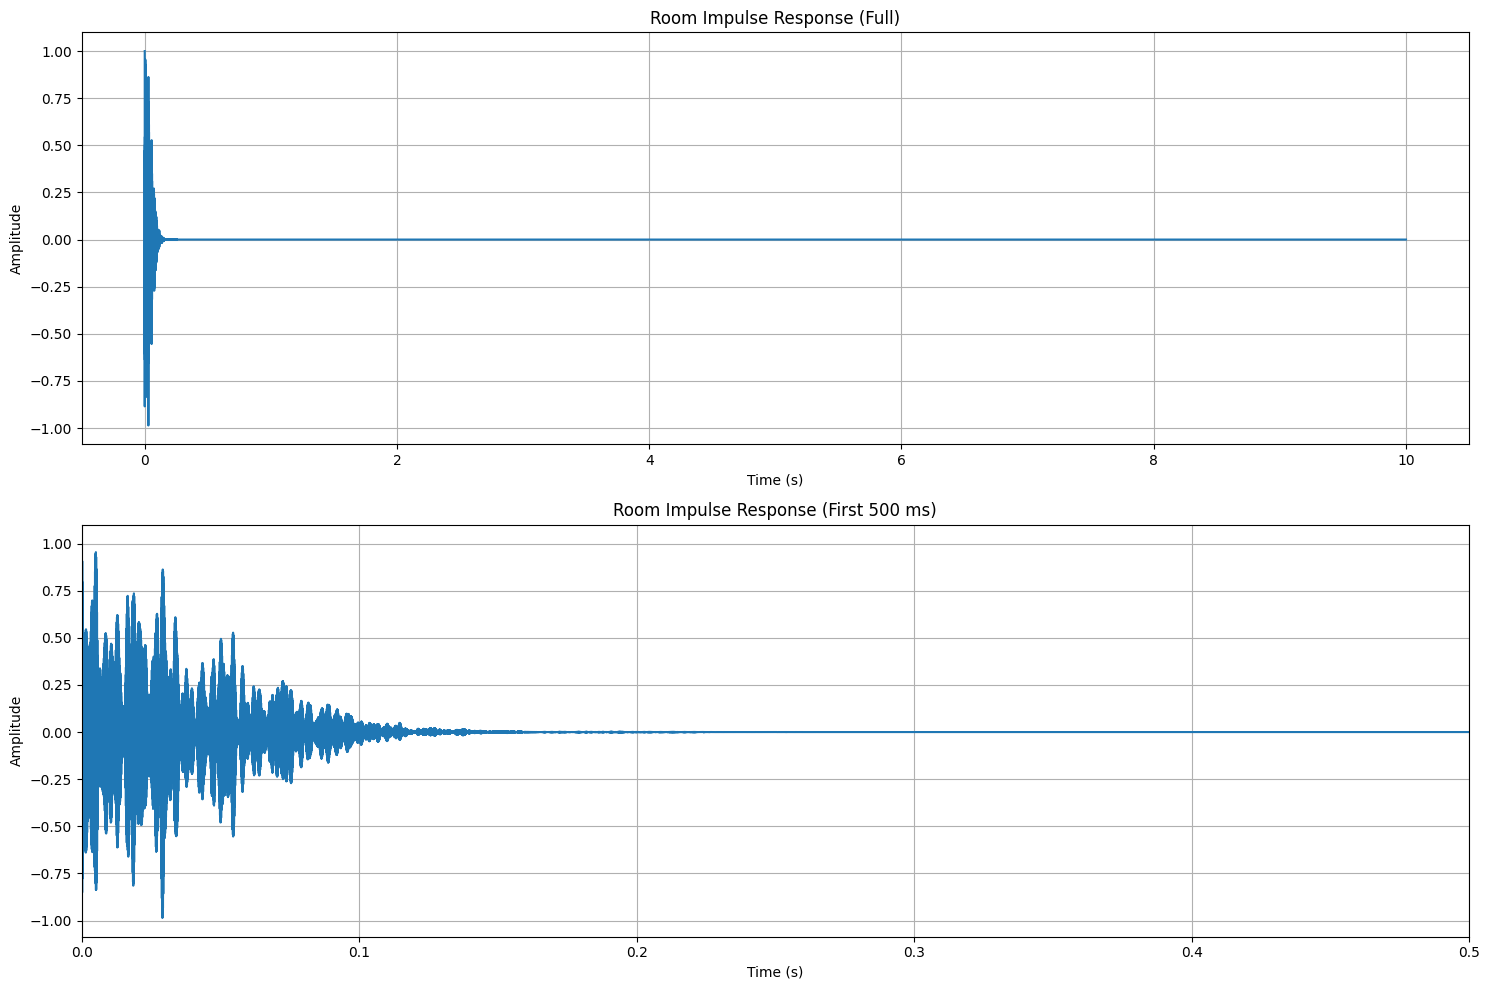

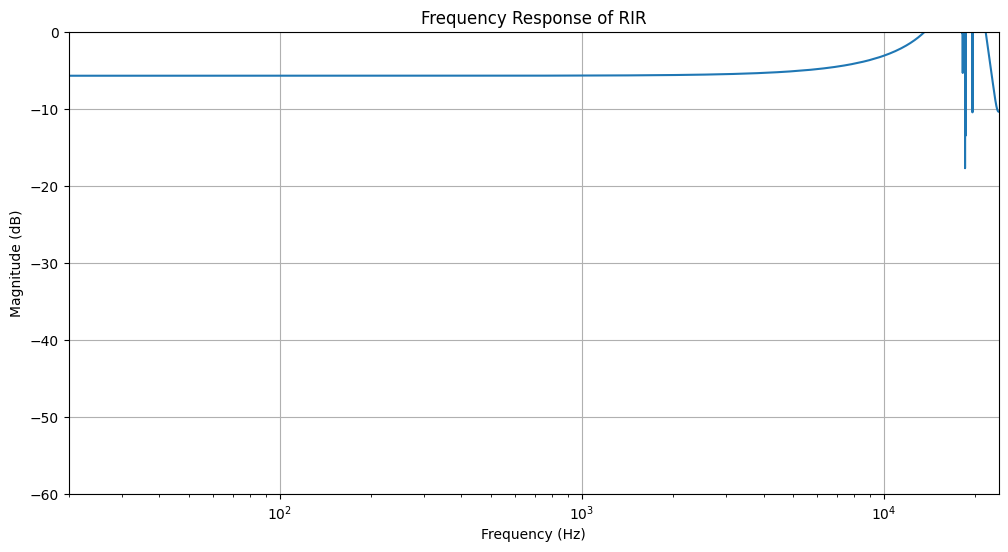

RIR statistics:
Length: 480000 samples
Duration: 10.00 seconds
Max amplitude: 1.0000
RMS value: 0.0233


In [9]:
# Define the relative path
relative_path = os.path.join('..', '..', 'Atiyeh-RIR-evaluation-Matlab', 'sounds', 'KT_GDP')

# Load the recorded sweep
recorded_sweep_path = 'KT_Unity_bf.wav'
fs_rec, recorded_sweep = wavfile.read(recorded_sweep_path)
recorded_sweep = np.array(recorded_sweep)
print('fs_recorded', fs_rec)

# Truncate one channel for deconvolution
rec_ch1 = recorded_sweep[:, 1] if recorded_sweep.ndim > 1 else recorded_sweep
print('record', recorded_sweep.shape)
print('record_ch1', rec_ch1.shape)

# Convert to float
rec_ch1 = rec_ch1.astype(float) / 32768.0

# Load the inverse filter
inverse_filter_path = 'inverse_filter.wav'
_, inverse_filter = wavfile.read(inverse_filter_path)
inverse_filter = inverse_filter.astype(float) / 32768.0

# Align signals
rec_ch1, inverse_filter = align_signals(rec_ch1, inverse_filter)

# Compute RIR
rir = compute_rir(rec_ch1, inverse_filter, fs_rec)

# Save the RIR
output_path = os.path.join(relative_path, 'RIR_KT_Unity_bf.wav')
wavfile.write(output_path, fs_rec, np.int16(rir * 32767))

print(f"Room Impulse Response generated and saved as {output_path}")

# Plot RIR and its spectrum
plot_rir_and_spectrum(rir, fs_rec)

# Print RIR statistics
print("RIR statistics:")
print(f"Length: {len(rir)} samples")
print(f"Duration: {len(rir)/fs_rec:.2f} seconds")
print(f"Max amplitude: {np.max(np.abs(rir)):.4f}")
print(f"RMS value: {np.sqrt(np.mean(rir**2)):.4f}")